In [18]:
import networkx as nx
import pandas as pd
import csv        
import numpy as np
import matplotlib.pyplot as plt
import operator
import statsmodels.api as sm
from scipy import stats

In [12]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 360.7 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 KB 636.4 kB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
BLOCK_RANGE = [10060850, 15076596]
NUM_BLOCK_GRAPH_SPLIT = 100

In [111]:
class DexPools:
    
    def __init__(self, file_path, dex_name):
        
        self.df_pools = pd.read_csv(file_path)
        self.name = dex_name
    
    def filter_first_blocks(self, pools_inp, block_first, block_last):
        df_pools_out = pools_inp.replace(np.nan, -1)
        df_pools_out = df_pools_out.astype({"FirstBlock":"int","LastBlock":"int"})
        df_pools_out = df_pools_out[df_pools_out.FirstBlock >= block_first]
        df_pools_out = df_pools_out[df_pools_out.FirstBlock <= block_last]
        return df_pools_out
    
    def filter_last_blocks(self, pools_inp, block_first, block_last):
        df_pools_out = pools_inp.replace(np.nan, -1)
        df_pools_out = df_pools_out.astype({"FirstBlock":"int","LastBlock":"int"})
        df_pools_out = df_pools_out[df_pools_out.LastBlock >= block_first]
        df_pools_out = df_pools_out[df_pools_out.LastBlock <= block_last]
        return df_pools_out
    
    def filter_count(self, pools_inp, cnt_min, cnt_max):
        df_pools_out = pools_inp.replace(np.nan, -1)
        df_pools_out = df_pools_out.astype({"CntTransfer":"int"})
        df_pools_out = df_pools_out[df_pools_out.CntTransfer >= cnt_min]
        df_pools_out = df_pools_out[df_pools_out.CntTransfer <= cnt_max]
        return df_pools_out
    
    def find_lost_pools(self):
        df_pools_out = self.filter_count(self.df_pools, 100000, 10000000000)
        df_pools_out = self.filter_last_blocks(df_pools_out, 0, 14500000)
        return df_pools_out
    
    def get_edge_cnt(self, token1, token2):
        df_pools = self.df_pools[self.df_pools.AddressToken0 == token1]
        df_pools = df_pools[df_pools.AddressToken1 == token2]
        if(len(df_pools) == 0):
            return None
        else:
            return df_pools.iloc[0]['CntTransfer']
        

In [1]:
COLUMN_NAME = ["AddressToken0","AddressToken1"]

class DexGraph:

    def __init__(self, df_pools, name):
        
        self.crypto_swaps_graph = nx.Graph()
        self.name = name
        
        symbol = []
        
        nx.set_node_attributes(self.crypto_swaps_graph, symbol, "symbol")

        for row in df_pools.index:
                
            sell_token = df_pools['AddressToken0'][row]
            buy_token = df_pools['AddressToken1'][row]
            
            self.add_node(self.crypto_swaps_graph, buy_token)
            self.add_node(self.crypto_swaps_graph, sell_token)
            
            sell_symbol = df_pools['SymbolToken0'][row]
            buy_symbol = df_pools['SymbolToken1'][row]
                        
            self.crypto_swaps_graph.nodes[sell_token]["symbol"] = sell_symbol
            self.crypto_swaps_graph.nodes[buy_token]["symbol"] = buy_symbol
            
            if(not(self.crypto_swaps_graph.has_edge(buy_token, sell_token))):
                self.crypto_swaps_graph.add_edge(buy_token, sell_token)
    
    def get_sorted_page_rank_nodes(self):
        
        page_rank = nx.pagerank(self.crypto_swaps_graph, alpha=0.9)
        page_rank = sorted(page_rank.items(), key = operator.itemgetter(1))
        return page_rank
    
    def get_centrality(self, node_name):
        
        page_rank = self.get_sorted_page_rank_nodes()
        vec_ans = [item[1] for item in page_rank 
                   if(item[0] == node_name)]
        if(len(vec_ans) == 0):
            return None
        return vec_ans[0]
    
    def get_degree(self, node_name):
        if(not self.crypto_swaps_graph.has_node(node_name)):
            return 0
        return self.crypto_swaps_graph.degree[node_name]

    def add_node(self, graph_input, token_input):
        if(not graph_input.has_node(token_input)):
            graph_input.add_node(token_input)
    
    def get_list_degree(self):
        degree_node_list = self.crypto_swaps_graph.degree()
        degree_list = [deg[1] for deg in degree_node_list]
        degree_list.sort()
        return degree_list

    def print(self, file_path_output):
        graph_file = open(file_path_output, 'w')
        graph_writer = csv.writer(graph_file)
        graph_writer.writerow(COLUMN_NAME)
        for edge in self.crypto_swaps_graph.edges:
             graph_writer.writerow(edge)

    def get_best_vertices(self, num):
        degree_node_list = self.crypto_swaps_graph.degree()
        degree_node = sorted(degree_node_list, key = lambda vertex: vertex[1])    
        return degree_node
    
    def get_count_deg(self, degree_list):
        count_deg = [(num, degree_list.count(num)) for num in degree_list]
        count_deg = [*set(count_deg)]
        count_deg = sorted(count_deg, key = lambda x: x[0])
        return count_deg
    
    def draw_plot_degree(self, degree_list, flag = False):
        
        count_deg = self.get_count_deg(degree_list)
        
        x = np.array([tmp[1] for tmp in count_deg])
        y = -0.8435 * x + 4.6
        print(x, y)

        plt.xscale('log')
        plt.yscale('log')
        plt.plot([tmp[1] for tmp in count_deg], [tmp[0] for tmp in count_deg])
        if(flag):
            plt.xlabel("Log Count Nodes")
            plt.ylabel("Log Degree")
            plt.show()
 
        plt.plot(x, y)
        plt.ylabel("Log Count Nodes")
        plt.xlabel("Log Degree")
        plt.title(f"{self.name} Log Log plot")
        
        plt.show()
    
    def print_info(self, is_avg_clustering = True, is_plot = True, is_page_rank = True,
            is_betweeness = False, is_eigen = False, is_closeness = False):
        
        print(f"Number of Nodes {self.name} is: ", self.crypto_swaps_graph.number_of_nodes())
        print(f"Number of Edges {self.name} is: ", self.crypto_swaps_graph.number_of_edges())
        print(f"Average Degree {self.name} is: ", (self.crypto_swaps_graph.number_of_edges() * 2) 
      / self.crypto_swaps_graph.number_of_nodes())
        if(is_avg_clustering):
            print(f"Average Clustering {self.name} is: ", nx.average_clustering(uni_graph.crypto_swaps_graph))
        if(is_plot):
            degree_list_graph = self.get_list_degree()
            self.draw_plot_degree(degree_list_graph)
            
        if(is_page_rank):    
            page_rank = self.get_sorted_page_rank_nodes()
            print(f"{self.name} Top 100 Tokens: ", page_rank[-1:-100:-1])
        
        if(is_betweeness):
            betweenness_centrality = nx.betweenness_centrality(dex_graph.crypto_swaps_graph)
            betweenness_centrality = sorted(betweenness_centrality.items(), key = operator.itemgetter(1))    
            print("Betweenness", betweenness_centrality)
            
        if(is_eigen):
            eigen_vector_centrality = nx.eigenvector_centrality(dex_graph.crypto_swaps_graph)
            print("EigenVector", eigen_vector_centrality)
        
        if(is_closeness):
            closeness_centrality = nx.closeness_centrality(dex_graph.crypto_swaps_graph)
            closeness_centrality = sorted(closeness_centrality.items(), key = operator.itemgetter(1))    
            print("Closeness", closeness_centrality)
            
        print("Components:")
        num_componenent = [x for x in nx.connected_components(self.crypto_swaps_graph)]
        print([len(component) for component in num_componenent])
        
        
        num_nodes = self.crypto_swaps_graph.number_of_nodes()
        max_edges = (num_nodes * (num_nodes - 1)) / 2
        print("Density of the graph is: ", (self.crypto_swaps_graph.number_of_edges() * 2) / (max_edges))
        
    def check_power_law(self):
            
        count_deg = self.get_count_deg(self.get_list_degree())

        x = [np.log(sample[0]) for sample in count_deg]
        y = [np.log(sample[1]) for sample in count_deg]
        x2 = sm.add_constant(x)
        est = sm.OLS(y, x2)
        print(est.fit().summary())
        print(est.fit().f_pvalue)


In [2]:
uni_dex = DexPools("../PoolsLiquidities/LiquidityPools/UniSwapV2.csv", "UniSwapV2")
sushi_dex = DexPools("../PoolsLiquidities/LiquidityPools/SushiSwap.csv", "SushiSwap")

NameError: name 'DexPools' is not defined

In [3]:
uni_lost_pools = uni_dex.find_lost_pools()
print(uni_lost_pools)

NameError: name 'uni_dex' is not defined

In [125]:
uni_graph =  DexGraph(uni_dex.df_pools, "UniSwapV2")
sushi_graph = DexGraph(sushi_dex.df_pools, "SushiSwap")

Number of Nodes UniSwapV2 is:  91290
Number of Edges UniSwapV2 is:  97064
Average Degree UniSwapV2 is:  2.1264979734910723
[87585  2297   584   271   158    97    69    47    29    25    12    12
    12    11     9     9     6     8     4     2     1     4     3     3
     1     3     3     1     1     1     1     3     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1] [-7.38733475e+04 -1.93291950e+03 -4.88004000e+02 -2.23988500e+02
 -1.28673000e+02 -7.72195000e+01 -5.36015000e+01 -3.50445000e+01
 -1.98615000e+01 -1.64875000e+01 -5.52200000e+00 -5.52200000e+00
 -5.52200000e+00 -4.67850000e+00 -2.99150000e+00 -2.99150000e+00
 -4.61000000e-01 -2.14800000e+00  1.22600000e+00  2.91300000e+00
  3.75650000e+00  1.22600000e+00  2.06950000e+00  2.06950000e+00
  3.75650000e+00  2.06950000e+00  2.06950000e+00  3.75650000e+00
  3.75650000e+00  3.75650000e+00  3.75650000e+00  2.06950000e+00
  3.75650000e+00  3.75650000e+00  3.75650000e+00  3

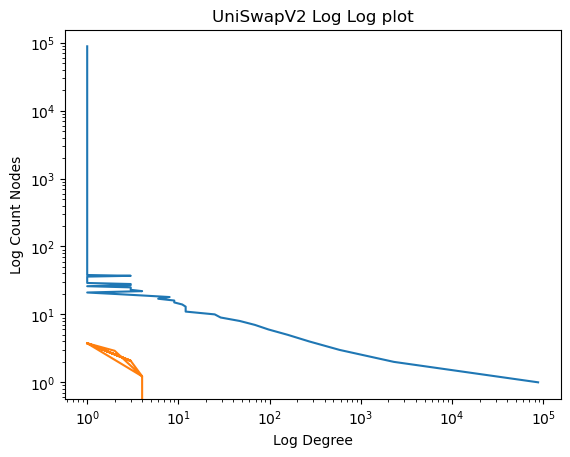

UniSwapV2 Top 100 Tokens:  [('0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 0.46025653768851466), ('0xdac17f958d2ee523a2206206994597c13d831ec7', 0.008780757796627134), ('0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', 0.007846557077996575), ('0x6b175474e89094c44da98b954eedeac495271d0f', 0.002992139468754134), ('0x1f9840a85d5af5bf1d1762f925bdaddc4201f984', 0.001152761852914216), ('0x2260fac5e5542a773aa44fbcfedf7c193bc2c599', 0.0007345503791313392), ('0x514910771af9ca656af840dff83e8264ecf986ca', 0.0004459073675010047), ('0x6b3595068778dd592e39a122f4f5a5cf09c90fe2', 0.0002847943105463551), ('0xd46ba6d942050d489dbd938a2c909a5d5039a161', 0.00023101694291809502), ('0x0bc529c00c6401aef6d220be8c6ea1667f6ad93e', 0.00021300361301132204), ('0xa91c82b6933105c23298e631a0c1be751d239162', 0.00019542607351709433), ('0x5f64ab1544d28732f0a24f4713c2c8ec0da089f0', 0.0001899990554702983), ('0x95ad61b0a150d79219dcf64e1e6cc01f0b64c4ce', 0.00018273382464074238), ('0x2b591e99afe9f32eaa6214f7b7629768c40eeb39', 0.00

In [126]:
uni_graph.print_info(is_avg_clustering = False)

In [103]:
sushi_graph.print_info()

Number of Nodes SushiSwap is:  2604
Number of Edges SushiSwap is:  3167
Average Degree SushiSwap is:  2.432411674347158


KeyboardInterrupt: 

In [93]:
ans = 0
for edge in sushi_graph.crypto_swaps_graph.edges():
    weight_one = uni_dex.get_edge_cnt(edge[0], edge[1])
    if(weight_one == None):
        weight_one = uni_dex.get_edge_cnt(edge[1], edge[0])
    weight_second = sushi_dex.get_edge_cnt(edge[0], edge[1])
    if(weight_second == None):
        weight_second = sushi_dex.get_edge_cnt(edge[1], edge[0])
#     print(weight_one, weight_second)
    if(weight_one != None and weight_second != None and weight_second != weight_one):
        print(weight_one / weight_second, sushi_graph.crypto_swaps_graph.nodes[edge[0]]["symbol"], 
             sushi_graph.crypto_swaps_graph.nodes[edge[1]]["symbol"])
        ans += 1
print(ans)

1.6666666666666667 WETH   比特币  
5187.75 WETH $BASED
32.305882352941175 WETH $CPHX
8.249821937321938 WETH $ROPE
0.005920663114268798 WETH $Stardust
2.776534859521332 WETH $TRDL
3.5 WETH $YFB
123.28472222222223 WETH 0xBTC
2240.4285714285716 WETH 10SET
24.83692539562924 WETH 1INCH


/tmp/ipykernel_13118/1606505541.py:11: RuntimeWarning: divide by zero encountered in long_scalars
  print(weight_one / weight_second, sushi_graph.crypto_swaps_graph.nodes[edge[0]]["symbol"],


inf WETH 2022
2.2 WETH 4YE5
159.5 WETH 69
0.0 WETH 911
1.3337754035659153 WETH AAVE
288.89473684210526 WETH ABY*
2.0833333333333335 WETH ACG
1.3333333333333333 WETH ACTN
7.503759398496241 WETH ADIDAS
inf WETH ADIDAS
9.674064171122994 WETH ADX
0.15137614678899083 WETH AERGO
0.1583290794623107 WETH AGLD
0.4375 WETH AIA
1302.8540372670807 WETH AKITA
8.472436946340913 WETH AKRO
187.9375 WETH ALCH
5.6710685594805765 WETH ALEPH
9.545019157088122 WETH ALN
23.27224824355972 WETH ALPA
0.5646393059522536 WETH ALPHA
16.333333333333332 WETH AMALGAM
8.907894736842104 WETH AMIS
15.681818181818182 WETH ANGEL
29.666666666666668 WETH ANKH
14.03959786622897 WETH ANKR
2.9191446225139988 WETH ANT
60.882716049382715 WETH ANT
6.138315539739027 WETH APE
8.439122549872058 WETH API3
1.25 WETH API4
2.0 WETH API5
1.3333333333333333 WETH API5
8371.818181818182 WETH APY
6.723684210526316 WETH AQU
4.68115671641791 WETH ARCH
0.006382639221318015 WETH ARCX
3.637766969761049 WETH ARMOR
99.46122026887281 WETH AUDIO
415

17.5 WETH MCIC
0.2796610169491525 WETH MEED
4.761363636363637 WETH META
886.2857142857143 WETH MFG
0.024822695035460994 WETH MIC
143.50233644859813 WETH MILK2
0.001010836764727743 WETH MIM
2.1666666666666665 WETH MIM
80.75676937441644 WETH MIR
10833.666666666666 WETH MITx
0.4227932960893855 WETH MM
18.22222222222222 WETH MM
3.0 WETH MOMO
781.1136363636364 WETH MOON
inf WETH MOSES
0.2632138517618469 WETH MOVE
8.153503551545402 WETH MPH
0.5770609318996416 WETH MPT11
72.03731343283582 WETH MSHIBA
3.6 WETH MSI
20.461002214385303 WETH MTA
2.8636043398619133 WETH MUST
23297.5 WETH MUTE
246.0948275862069 WETH MVI
8.875 WETH MYFI
23.744107744107744 WETH MYFI
1.6 WETH MYM
0.035288828950325916 WETH MetaCat
9.346370051429254 WETH Metis
0.03189300411522634 WETH MoonGain
4.333333333333333 WETH Morf
5.9248322147651 WETH NAOS
5.135299806576402 WETH NCT
2443.0 WETH NDR
10.187527740790058 WETH NDX
344.2 WETH NERDLING
0.0 WETH NFTL
0.8124840955018336 WETH NFTX
0.3076923076923077 WETH NGN
12.714118564742

44.14071294559099 WETH ETHV
1.0555555555555556 WETH ETM
inf WETH ETRD
2.125 WETH FCKS
10.666666666666666 WETH FEM
16.9375 WETH FIDA
3.3333333333333335 WETH FMT
291.94615384615383 WETH FNT
2.657067587209302 WETH FNX
2.2 WETH FREN
162.3507462686567 WETH FRONT
1052.3333333333333 WETH GENE
12.536822724881642 WETH GMEE
0.0 WETH GODS
0.1188118811881188 WETH GOLD
11.352914180816889 WETH GOVI
7.580850398080868 WETH GRT
0.8214285714285714 WETH GUP
132.14594594594595 WETH HEZ
2412.1772151898736 WETH HOGE
0.0 WETH HOP
8.583817829457365 WETH HVN
0.8242296139726332 WETH ICE
8.723965385294637 WETH ID
0.0 WETH IMX
3.560842717035961 WETH INJ
54.02040816326531 WETH JULIEN
inf WETH Jay
54.46440677966102 WETH KEYS
9.367245657568239 WETH KICK
0.0 WETH KNC
22.166666666666668 WETH LAGER
2.5 WETH LTE2
7.611650160599572 WETH LUNA
6.766454352441613 WETH LYM
0.0 WETH MEGAFLOKIDINGER
52.357057057057055 WETH MEME
7.6 WETH MEMO
3.2591595378480624 WETH MLN
25.625 WETH MUA
4.639820114472609 WETH MUSH
inf WETH Meta
3

36.71212121212121 DAI SHIB
5.392857142857143 DAI UNI
36.239666666666665 DAI USDC
17254.0 DAI ZAI
9.0 DAI DCB
30.853846153846153 DAI LINK
0.030728964715005816 DAI MANA
0.00016391561624075926 DAI OHM
4.666666666666667 DAI OOKS
0.7083333333333334 DAI QUA
40.0 DAI RLC
221.80666666666667 DAI UNI
1.5 DAI XDL
0.4397463002114165 DAI cDAI
0.6512141280353201 DAI nTrump
0.10144927536231885 1INCH SUSHI
15.142857142857142 1INCH UNI
27.945454545454545 1INCH USDC
62.0 ETHMNY ERC223
inf ETHMNY HOT
inf ETHMNY UNI
inf ETHMNY XYO
0.0011385199240986717 SUSHI BAO
1714.75 SUSHI KIMCHI
2.588235294117647 SUSHI OOKS
0.1779508687837028 SUSHI POT
0.43243243243243246 SUSHI AMIS
0.14814814814814814 SUSHI AMPL
0.8333333333333334 SUSHI COMP
0.48172757475083056 SUSHI MOUTAI
21.715384615384615 SUSHI SHROOM
0.2899056933286762 SUSHI USDC
0.0005763688760806917 SUSHI xSUSHI
0.9664570230607966 SUSHI UNI
0.8275862068965517 SUSHI YFI
4.903225806451613 UNI STAKE
278.45454545454544 UNI LINK
inf UNI LRC
6.72 UNI MATIC
7.0 UNI M

KeyboardInterrupt: 

In [ ]:
uni_graph.print_info(is_avg_clustering = False)

In [ ]:
sushi_graph.print_info(is_avg_clustering = False, is_page_rank = False)

<h2><span style="color:orange">Graphs Within TimeLimit</span></h2>

In [22]:
# graphs_blocks = []
centrality_weth = []
centrality_usdc = []
centrality_usdt = []
centrality_dai = []
centrality_uni = []

degree_weth = []
degree_usdc = []
degree_usdt = []
degree_dai = []
degree_uni = []

len_count = (BLOCK_RANGE[1] - BLOCK_RANGE[0]) // NUM_BLOCK_GRAPH_SPLIT
block_nums = []
for i in range(BLOCK_RANGE[0], BLOCK_RANGE[1] - len_count, len_count):
    dex_filtered = uni_dex.filter_first_blocks(uni_dex.df_pools, 10060850, i + len_count)
    graph_new = DexGraph(dex_filtered, "UniSwapV2")
#     graphs_blocks.append(graph_new)
    centrality_weth.append(graph_new.get_centrality("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"))
    centrality_usdc.append(graph_new.get_centrality("0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"))
    centrality_usdt.append(graph_new.get_centrality("0xdac17f958d2ee523a2206206994597c13d831ec7"))
    centrality_dai.append(graph_new.get_centrality("0x6b175474e89094c44da98b954eedeac495271d0f"))
    centrality_uni.append(graph_new.get_centrality("0x1f9840a85d5af5bf1d1762f925bdaddc4201f984"))
    
    degree_weth.append(graph_new.get_degree("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"))
    degree_usdc.append(graph_new.get_degree("0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"))
    degree_usdt.append(graph_new.get_degree("0xdac17f958d2ee523a2206206994597c13d831ec7"))
    degree_dai.append(graph_new.get_degree("0x6b175474e89094c44da98b954eedeac495271d0f"))
    degree_uni.append(graph_new.get_degree("0x1f9840a85d5af5bf1d1762f925bdaddc4201f984"))
    

    block_nums.append(i)
    print(i, centrality_weth[-1], graph_new.crypto_swaps_graph.number_of_edges())

10060850 0.3213592297667718 268
10111007 0.30820035925838796 427
10161164 0.32518657997269124 618
10211321 0.3633345460321924 996
10261478 0.38156745104593487 1372
10311635 0.38019653627993083 1593
10361792 0.389956433918622 2062
10411949 0.3931134696797852 2499
10462106 0.3905681389060854 2790
10512263 0.39046990029704176 3127
10562420 0.39908487499245865 3986
10612577 0.4054173531510273 4675
10662734 0.40893855400953816 5561
10712891 0.41041101393180035 6661
10763048 0.4135584593049954 7887
10813205 0.41187197110908186 8989
10863362 0.40420938594059747 10248
10913519 0.40755785008463324 11985
10963676 0.4043224791334409 13727
11013833 0.4105534469633591 15365
11063990 0.407027827318423 17412


KeyboardInterrupt: 

In [228]:
centralities_weth = []
for graph in graphs_blocks:
#     graph.print_info(is_avg_clustering = False, is_plot = False)
    centralities_weth.append(graph.get_centrality("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"))
print(centralities_weth)

[0.3213592297667718, 0.30820035925838796, 0.32518657997269124, 0.3633345460321924, 0.38156745104593487, 0.38019653627993083, 0.389956433918622, 0.3931134696797852, 0.3905681389060854, 0.39046990029704176, 0.39908487499245865, 0.4054173531510273, 0.40893855400953816, 0.41041101393180035, 0.4135584593049954, 0.41187197110908186, 0.40420938594059747, 0.40755785008463324, 0.4043224791334409, 0.4105534469633591, 0.407027827318423, 0.40833570551465387, 0.4166069241525893, 0.416457388862167, 0.4079197495556539, 0.4076257240454043, 0.4065632027939535, 0.41498560629120423, 0.4140689418177998, 0.41307466570368706, 0.41234756500054803, 0.40161142521221116, 0.4010049901980023, 0.4008280782499014, 0.40024422304926527, 0.40013747924553345, 0.39984971470153324, 0.399409222891998, 0.399042974342279, 0.39858505812380246, 0.39876582541663225, 0.3989815775169711, 0.41014083260114176, 0.41025942640319385, 0.41213144679654773, 0.4133769013618525, 0.41408181831642793, 0.41619175649633017, 0.4179982382572171

100 100


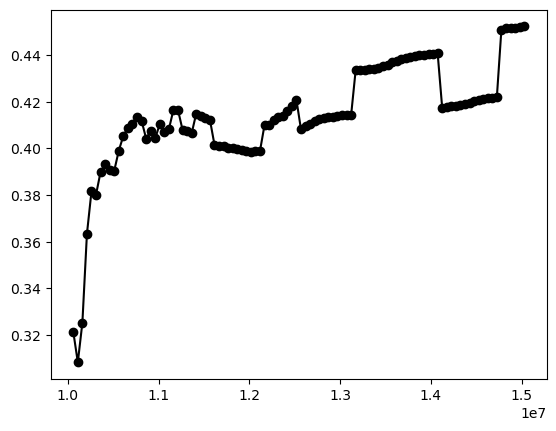

In [229]:
print(len(block_nums), len(centralities_weth))
plt.plot(block_nums, centralities_weth,'-ok')
plt.show()

100 100


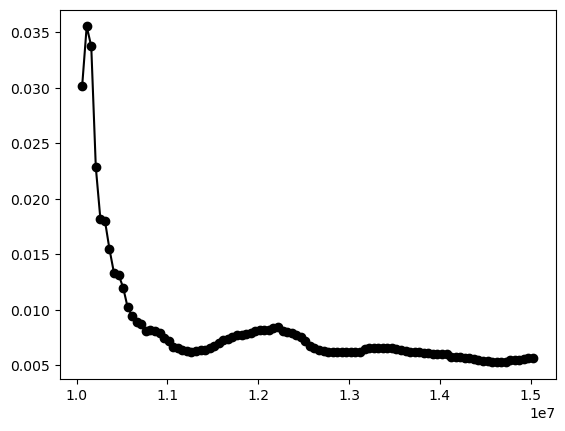

In [17]:
print(len(block_nums), len(centrality_usdc))
plt.plot(block_nums, centrality_usdc,'-ok')
plt.show()

100 100


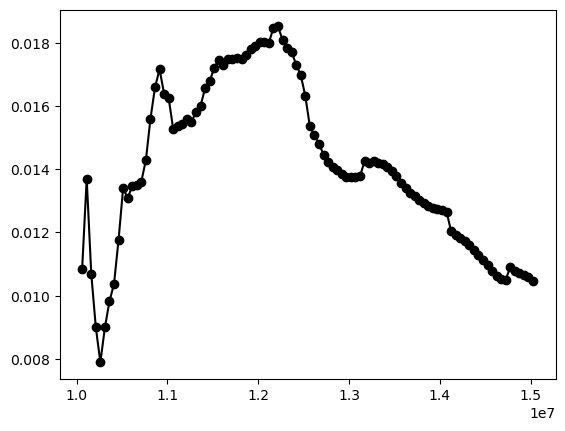

In [14]:
print(len(block_nums), len(centrality_usdt))
plt.plot(block_nums, centrality_usdt,'-ok')
plt.show()

100 100


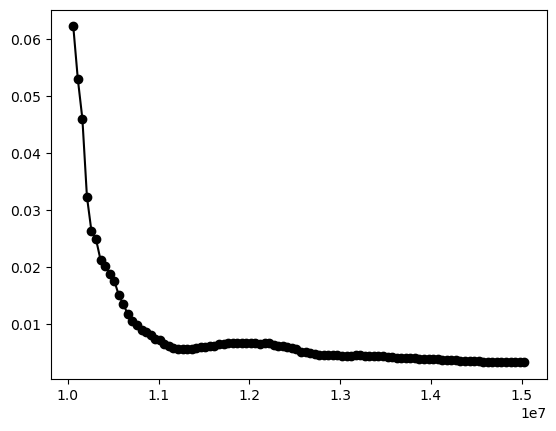

In [15]:
print(len(block_nums), len(centrality_dai))
plt.plot(block_nums, centrality_dai,'-ok')
plt.show()

100 100


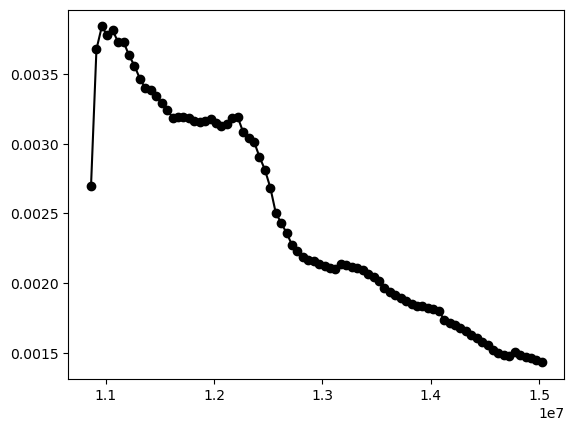

In [16]:
print(len(block_nums), len(centrality_uni))
plt.plot(block_nums, centrality_uni,'-ok')
plt.show()

100 100


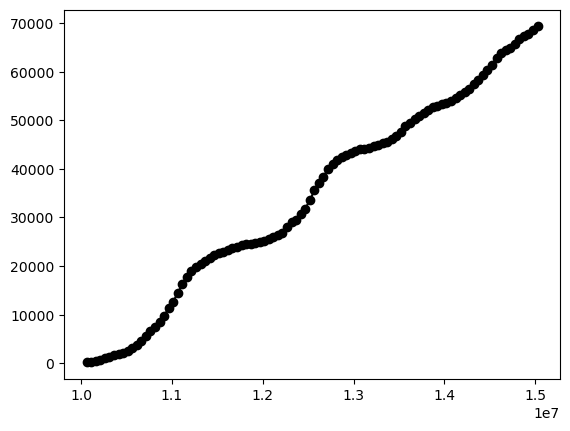

In [28]:
print(len(block_nums), len(degree_weth))
plt.plot(block_nums, degree_weth,'-ok')
plt.show()

100 100


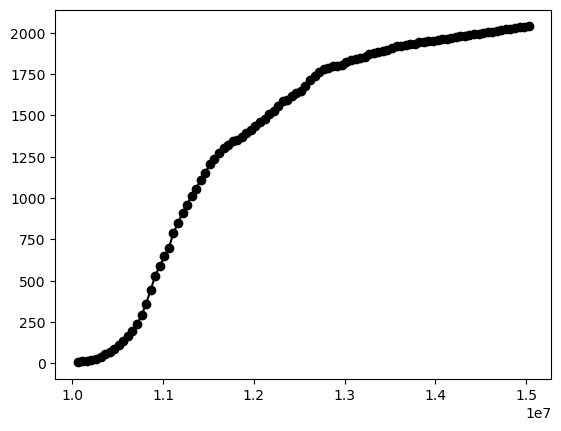

In [29]:
print(len(block_nums), len(degree_usdt))
plt.plot(block_nums, degree_usdt,'-ok')
plt.show()

100 100


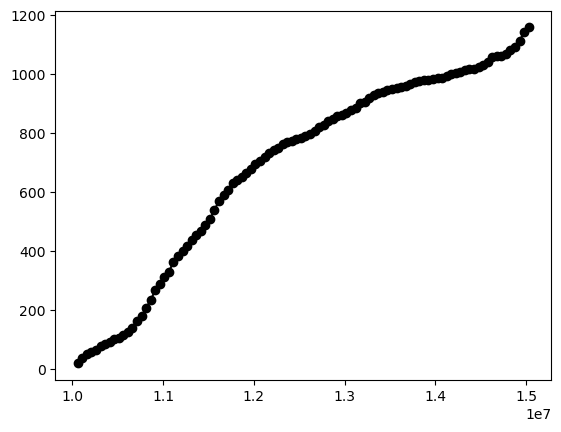

In [30]:
print(len(block_nums), len(degree_usdc))
plt.plot(block_nums, degree_usdc,'-ok')
plt.show()

100 100


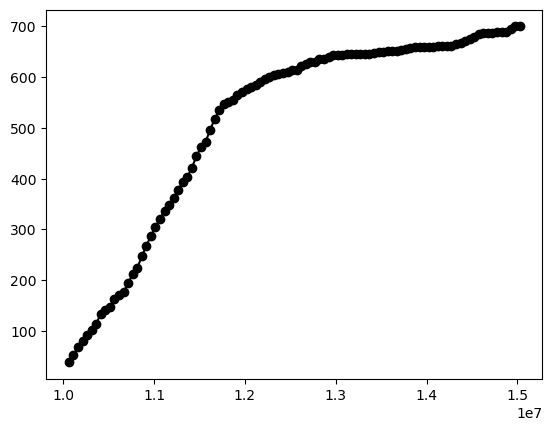

In [31]:
print(len(block_nums), len(degree_dai))
plt.plot(block_nums, degree_dai,'-ok')
plt.show()

100 100


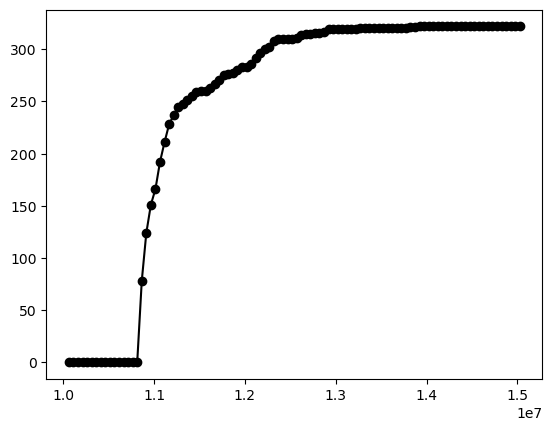

In [32]:
print(len(block_nums), len(degree_uni))
plt.plot(block_nums, degree_uni,'-ok')
plt.show()

In [231]:
centralities_usd = []
for graph in graphs_blocks:
#     graph.print_info(is_avg_clustering = False, is_plot = False)
    centralities_usd.append(graph.get_centrality("0xdac17f958d2ee523a2206206994597c13d831ec7"))

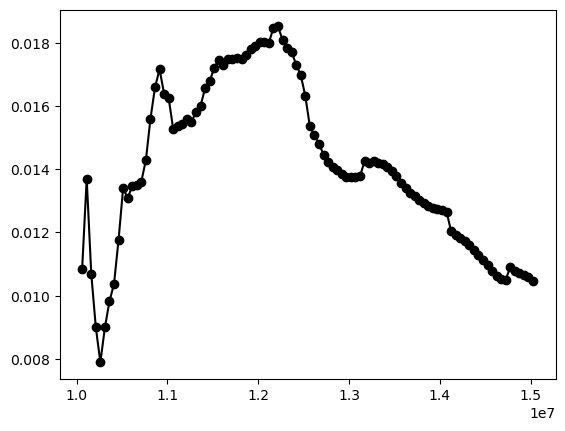

In [232]:
plt.plot(block_nums, centralities_usd,'-ok')
plt.show()

In [ ]:
# graphs_blocks = []
centrality_weth = []
edges = []
nodes = []
len_count = (BLOCK_RANGE[1] - BLOCK_RANGE[0]) // NUM_BLOCK_GRAPH_SPLIT
block_nums = []
for i in range(BLOCK_RANGE[0], BLOCK_RANGE[1] - len_count, len_count):
    dex_filtered = uni_dex.filter_first_blocks(uni_dex.df_pools, BLOCK_RANGE[0], i + len_count)
    graph_new = DexGraph(dex_filtered, "UniSwapV2")
    edges.append(graph_new.crypto_swaps_graph.number_of_edges())
    nodes.append(graph_new.crypto_swaps_graph.number_of_nodes())
#     graphs_blocks.append(graph_new)
    centrality_weth.append(graph_new.get_centrality("0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"))
    block_nums.append(i)
    print(i, graph_new.crypto_swaps_graph.number_of_edges())

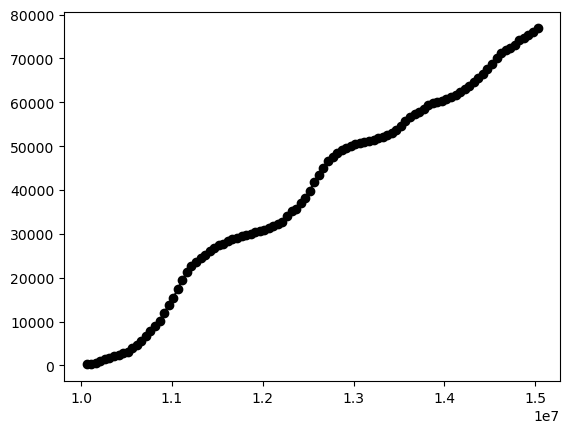

In [46]:
plt.plot(block_nums, edges,'-ok')
plt.show()

In [35]:
plt.plot(block_nums, nodes,'-ok')
plt.show()

NameError: name 'block_nums' is not defined

<h2> <span style="color:orange">Checking whether it is powerlaw or not</span></h2>

In [95]:
uni_graph.check_power_law()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     37.24
Date:                Wed, 15 Feb 2023   Prob (F-statistic):           1.75e-07
Time:                        20:08:24   Log-Likelihood:                -99.493
No. Observations:                  50   AIC:                             203.0
Df Residuals:                      48   BIC:                             206.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5974      0.546      8.413      0.0

In [104]:
sushi_graph.check_power_law()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     26.20
Date:                Wed, 15 Feb 2023   Prob (F-statistic):           3.95e-05
Time:                        21:47:23   Log-Likelihood:                -40.562
No. Observations:                  24   AIC:                             85.12
Df Residuals:                      22   BIC:                             87.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9980      0.556      7.186      0.0

<h2> <span style="color:orange">Communities</span></h2>

In [54]:
from networkx.algorithms import community
import itertools

In [55]:
communities_uni_graph = community.louvain_communities(uni_graph.crypto_swaps_graph, seed=123)
communities_sushi_graph = community.louvain_communities(sushi_graph.crypto_swaps_graph, seed=123)

In [56]:
print(sorted([len(x) for x in communities_uni_graph]))

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 7, 161, 215, 2942]


In [57]:
print(sorted([len(x) for x in communities_sushi_graph]))

[2, 2, 2, 2, 2, 2, 2, 3, 5, 10, 20, 21, 270]


<h2><span style="color:orange">Plot degrees eliminating low degree nodes</span></h2>

In [16]:
from copy import copy
def eliminate_nodes_low_degree(lim_degree, graph_inp):
    new_graph = graph_inp.copy()
    for node in graph_inp.nodes:
        if(graph_inp.degree[node] > lim_degree):
            new_graph.remove_node(node)
    return new_graph

def get_degree_list(graph_inp):
    degree_node_list = graph_inp.degree()
    degree_list = [deg[1] for deg in degree_node_list]
    degree_list.sort()
    return degree_list

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

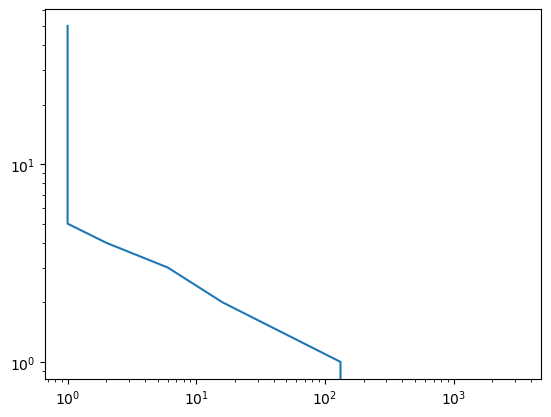

In [59]:
new_graph = eliminate_nodes_low_degree(100, uni_graph.crypto_swaps_graph)
degree_list_sushi_new = get_degree_list(new_graph)
print(degree_list_sushi_new)
draw_plot_degree(degree_list_sushi_new)

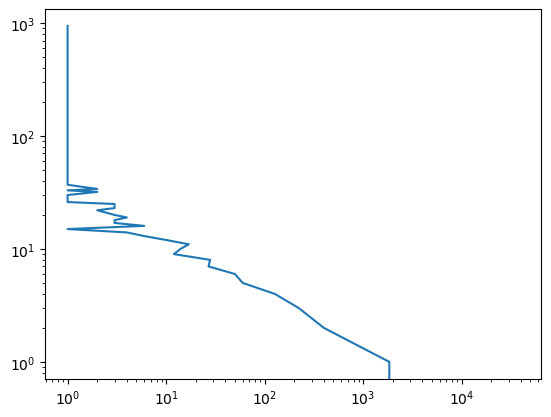

In [28]:
new_graph = eliminate_nodes_low_degree(1000, uni_graph.crypto_swaps_graph)
degree_list_sushi_new = get_degree_list(new_graph)
draw_plot_degree(degree_list_sushi_new)

<h2><span style="color:orange">Plot degrees Largest Community</span></h2>

In [29]:
def just_nodes_remain(graph_inp, list_remains):
    graph_new = graph_inp.copy()
    for node in graph_inp.nodes:
        if(not node in list_remains):
            graph_new.remove_node(node)
    return graph_new

In [81]:
communities_uni_graph = community.louvain_communities(uni_graph.crypto_swaps_graph, seed=123)
graph_uni_new = just_nodes_remain(uni_graph.crypto_swaps_graph, 
                                  communities_uni_graph[0])

[2, 3, 3, 4, 4, 5, 6, 7]


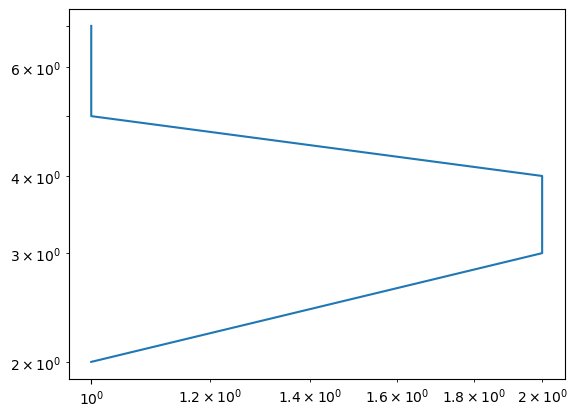

In [82]:
degree_list_uni_new2 = get_degree_list(graph_uni_new)
draw_plot_degree(degree_list_uni_new2)
print(degree_list_uni_new2)

<h2><span style="color:orange">Limited Count graph</span></h2>

In [40]:
uni_graph =  DexGraph("Graphs/limit-uniswap.csv")
sushi_graph = DexGraph("Graphs/limit-sushiswap.csv")
print("Number of Nodes Uniswap is: ", uni_graph.crypto_swaps_graph.number_of_nodes())
print("Number of Edges Uniswap is: ", uni_graph.crypto_swaps_graph.number_of_edges())

print("Number of Nodes Sushiswap is: ", sushi_graph.crypto_swaps_graph.number_of_nodes())
print("Number of Edges Sushiswap is: ", sushi_graph.crypto_swaps_graph.number_of_edges())

Number of Nodes Uniswap is:  3353
Number of Edges Uniswap is:  3611
Number of Nodes Sushiswap is:  343
Number of Edges Sushiswap is:  363


In [41]:
degree_list_uni = uni_graph.get_list_degree()
degree_list_sushi = sushi_graph.get_list_degree()

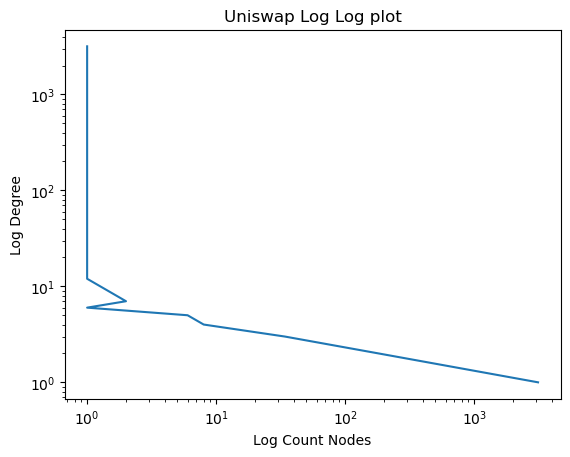

In [42]:
draw_plot_degree(degree_list_uni)
plt.xlabel("Log Count Nodes")
plt.ylabel("Log Degree")
plt.title("Uniswap Log Log plot")
plt.show()

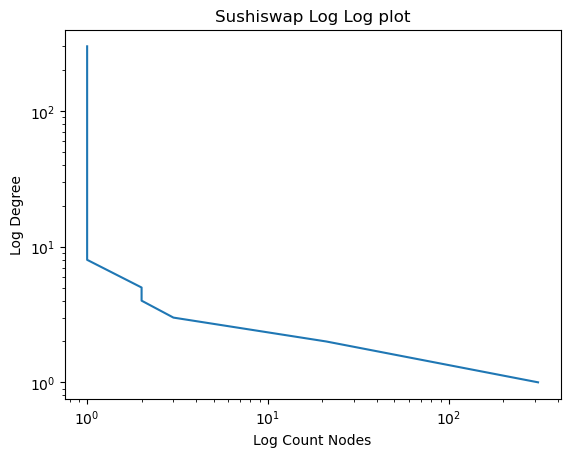

In [43]:
draw_plot_degree(degree_list_sushi)
plt.xlabel("Log Count Nodes")
plt.ylabel("Log Degree")
plt.title("Sushiswap Log Log plot")
plt.show()

<h2><span style="color:orange">All nodes with degree at least limit</span></h2>

In [13]:
def elim_till_limit(graph_inp, lim):
    new_graph = graph_inp.copy()
    while(True):
        flag = False
        temp_graph = new_graph.copy()
        for node in temp_graph.nodes:
            if(temp_graph.degree[node] <= lim):
                new_graph.remove_node(node)
                flag = True
        if(not flag):
            break
    return new_graph

[]
[]


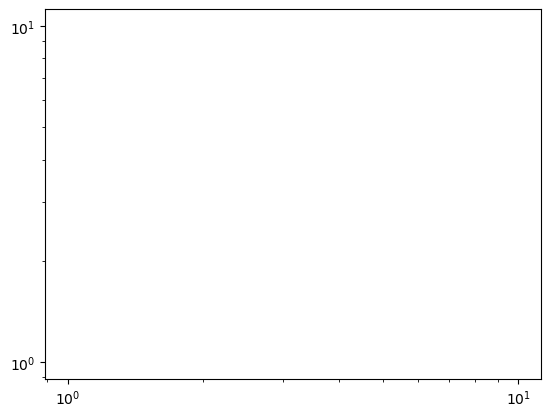

In [45]:
new_graph = elim_till_limit(uni_graph.crypto_swaps_graph, 100000)
degree_list_sushi_new = get_degree_list(new_graph)
print(degree_list_sushi_new)
draw_plot_degree(degree_list_sushi_new)
print(new_graph.nodes)

[]
[]


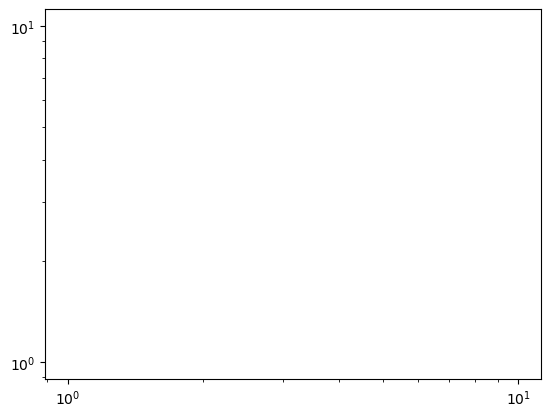

In [37]:
new_graph = elim_till_limit(sushi_graph.crypto_swaps_graph, 3)
degree_list_sushi_new = get_degree_list(new_graph)
print(degree_list_sushi_new)
draw_plot_degree(degree_list_sushi_new)
print(new_graph.nodes)

<h2><span style="color:orange">Max Clique</span></h2>

In [ ]:
from networkx.algorithms.approximation import clique
cliques = nx.find_cliques(uni_graph.crypto_swaps_graph)
for clique in cliques:
    print(clique)

In [ ]:
cliques = nx.find_cliques(sushi_graph.crypto_swaps_graph)
for clique in cliques:
    print(clique)

<h2><span style="color:orange">Delete specific node</span></h2>


In [14]:
def remove_nodes(nodes_in_list, graph_inp):
    graph_new = graph_inp.copy()
    for node in graph_inp.nodes:
        if(node in nodes_in_list):
            graph_new.remove_node(node)
    return graph_new

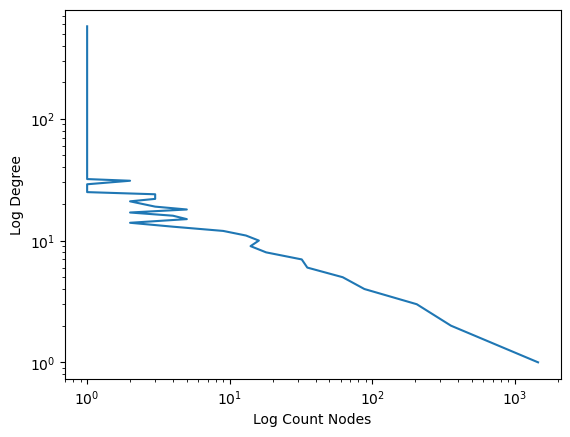

In [19]:
new_graph = remove_nodes(['WETH', 'USDC', 'USDT'],
                         uni_graph.crypto_swaps_graph)
new_graph = elim_till_limit(new_graph, 0)
degree_list_uni_new = get_degree_list(new_graph)
draw_plot_degree(degree_list_uni_new, True)